In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from rocket import Rocket
from tqdm import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle

In [2]:
# пропишем пути до наших файлов и считаем так чтобы все было ок
train_path = "data/Ham_TRAIN.txt"
test_path = "data/Ham_TEST.txt"

train = pd.read_csv(train_path, sep="  ", header=None)
test = pd.read_csv(test_path, sep="  ", header=None)

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
# поделим на лейблы и ряды
X_train, y_train = train.drop(columns=[0]), train[0]
X_test, y_test = test.drop(columns=[0]), test[0]

Я реализовал алгоритм Rocket. С точки зрения пользования у него очень простой интерфейс. Надо подать значения датафреймом и все!

Для пользования есть по факту 3 метода

1) ```__init__(k, weight_type)```, куда мы подаем желаемое количество ядер и желаемый тип ядра, один из трех: normal, binary, ternary

2) ```fit(X, y, classifier_args)```, куда мы должны подать нашу тренировочную выборку и ответы к ней и по желанию аргументы к классификатору. Генерация случайных ядер происходит именно на этой стадии. Можно считать, что ядра генерируются тогда когда мы фитимся на выборку. В общем случае это может быть не так, в нашем случае это так. А далее мы тренируем RidgeClassifier на том что получили

3) ```predict(X)``` , куда мы подаем нашу тестовую выборку и получаем ответы. Внутри к ней применяются полученные на fit ядра и далее применяется классификатор

Остальные подробности внутри класса)

In [4]:
# эта штука очень долго считается, я ее считал на коллабе около часа
# результаты с колаба подгружаются дальше

###### DANGER!! LONG COMPUTATIONAL ZONE ###########

ENTER_DANGER_ZONE = False

if ENTER_DANGER_ZONE:
    weight_types = ["normal", "binary", "ternary"]
    k_grid = [10, 50, 100, 500, 1000, 5000, 10000]
    repeats = 20

    results = {}

    for weight in tqdm(weight_types):
        results[weight] = {}
        for k in k_grid:
            results[weight][k] = []
            for i in range(repeats):
                rocket = Rocket(k=k, weight_type=weight)
                rocket.fit(X_train, y_train)
                y_pred = rocket.predict(X_test)
                acc = accuracy_score(y_test, y_pred)

                results[weight][k].append(acc)
else:
    path_test = "res.pickle"
    with open(path_test, "rb") as f:
        results = pickle.load(f)

In [47]:
# сделаем функцию чтобы рисовать матрицу статистических различий если они < 0.05
def display_differences_pvals(data):
    matrix = []

    # Get the list names
    list_names = list(data.keys())

    # Find the maximum length among list names
    max_name_length = max(len(str(name)) for name in list_names)

    # Calculate the total width for each column
    col_width = max(max_name_length, len(str(max_name_length))) + 2

    # Print the column names
    print(" " * col_width, end="")
    for name in list_names:
        print(f"{name:>{col_width}}", end="")
    print()

    # Iterate over the data and call the function f for each pair of lists
    for i, name_i in enumerate(list_names):
        print(f"{name_i:>{col_width}}", end="")
        for j, name_j in enumerate(list_names):
            result = (
                stats.mannwhitneyu(
                    data[name_i], data[name_j], alternative="two-sided"
                ).pvalue
                < 0.05
            )
            print(f"{result:>{col_width}}", end="")
        print()

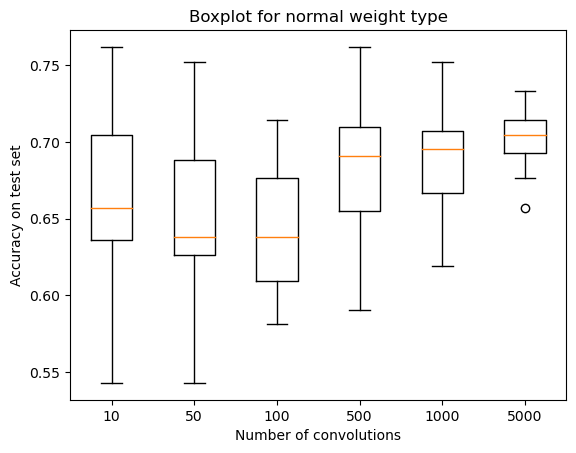

          10    50   100   500  1000  5000
    10     0     0     0     0     0     1
    50     0     0     0     1     1     1
   100     0     0     0     1     1     1
   500     0     1     1     0     0     0
  1000     0     1     1     0     0     0
  5000     1     1     1     0     0     0


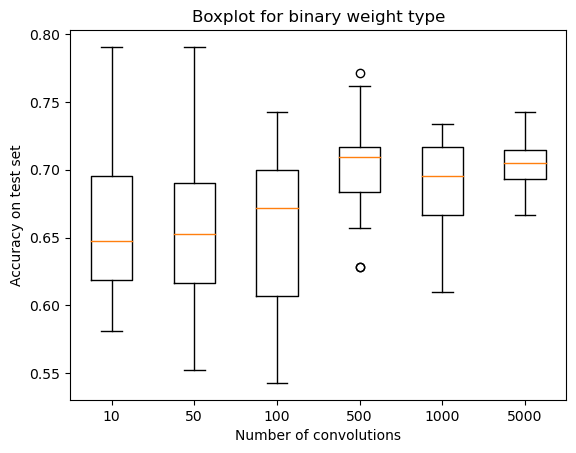

          10    50   100   500  1000  5000
    10     0     0     0     1     1     1
    50     0     0     0     1     1     1
   100     0     0     0     1     1     1
   500     1     1     1     0     0     0
  1000     1     1     1     0     0     0
  5000     1     1     1     0     0     0


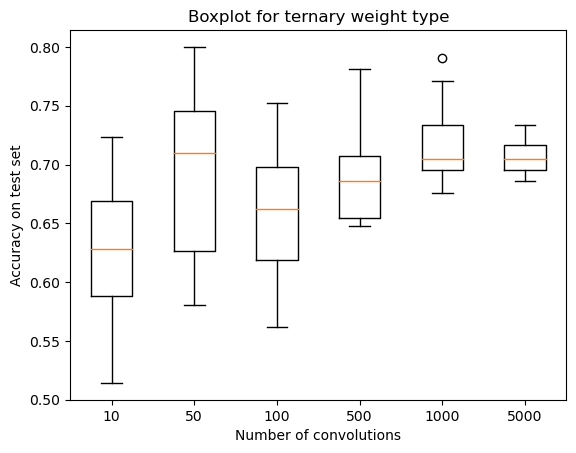

          10    50   100   500  1000  5000
    10     0     1     0     1     1     1
    50     1     0     0     0     0     0
   100     0     0     0     0     1     1
   500     1     0     0     0     1     1
  1000     1     0     1     1     0     0
  5000     1     0     1     1     0     0


In [48]:
# рисуем боксплоты для каждого случая ядра и каждого параметра k
# на боксплотах по умолчанию видим еще и квантили и разброс от квантилей на 1.5IQR
for key in results.keys():
    plt.boxplot(
        [val for key, val in results[key].items()],
        labels=list(results["normal"].keys()),
    )
    plt.title("Boxplot for {} weight type".format(key))
    plt.ylabel("Accuracy on test set")
    plt.xlabel("Number of convolutions")
    plt.show()
    display_differences_pvals(results[key])

По итогу получается что чем больше ядер мы возьмем, тем качество становится лучше, а еще видим, что снижается разброс между квартилями. Для нормального ядра видим, что есть тенденция к тому, что увеличивая количество случайных ядер вначале, получаем прирост в качестве, но у 500-1000-5000 уже не видим разницы. 

На Тернарном ядре выскочил интересный результат, что 50 разных ядер не отличаются статистичеки от 1000 и 5000. Авторы писали что мы постепенно видим прирост качества с увеличением ядер и что не всегда есть статистические различия. В целом мы можем наблюдать примерно тот же результат, у них правда он кажется сильнее.

Посмотрим еще насколько брать разные ядра хорошо или плохо


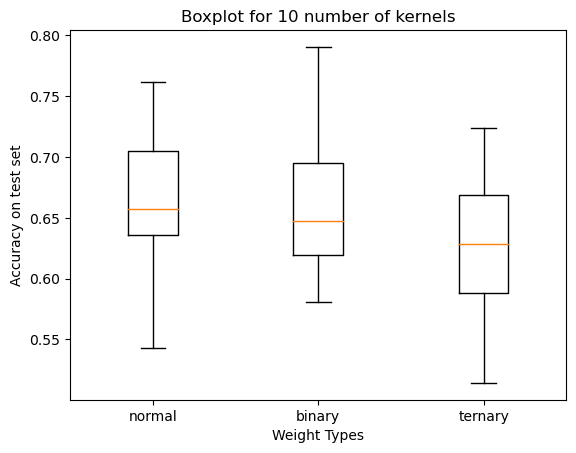

            normal   binary  ternary
   normal        0        0        0
   binary        0        0        0
  ternary        0        0        0


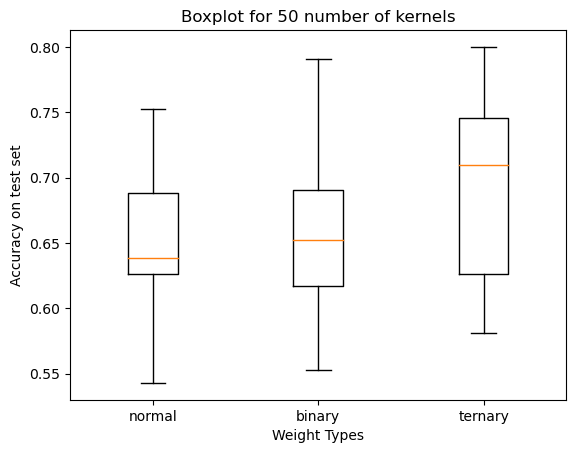

            normal   binary  ternary
   normal        0        0        0
   binary        0        0        0
  ternary        0        0        0


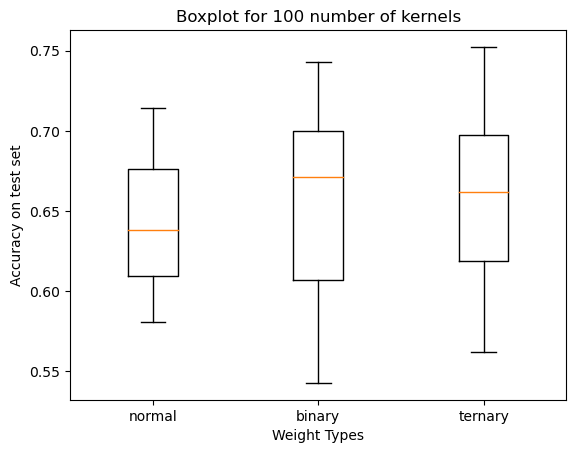

            normal   binary  ternary
   normal        0        0        0
   binary        0        0        0
  ternary        0        0        0


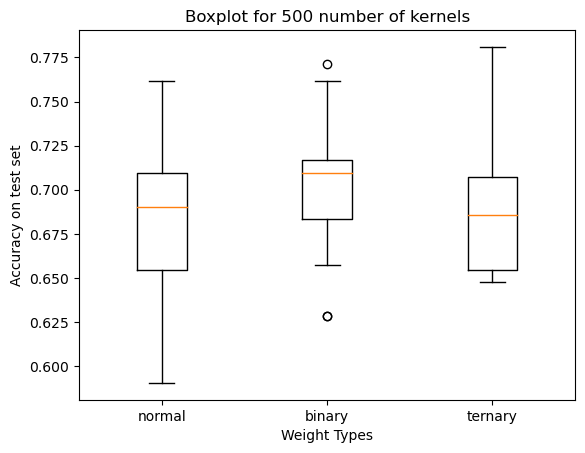

            normal   binary  ternary
   normal        0        0        0
   binary        0        0        0
  ternary        0        0        0


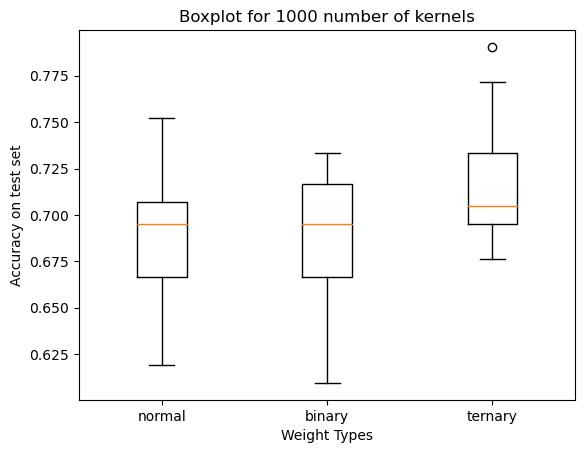

            normal   binary  ternary
   normal        0        0        1
   binary        0        0        0
  ternary        1        0        0


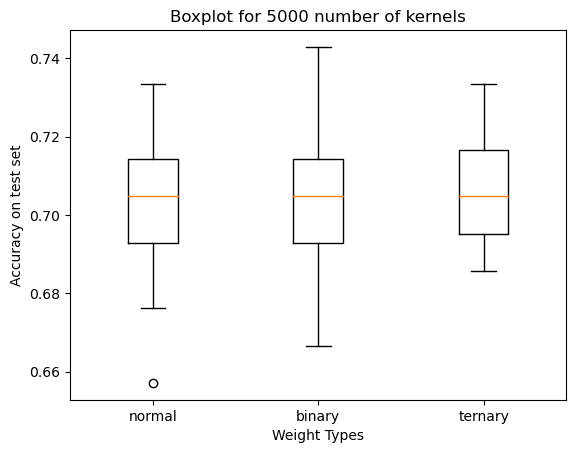

            normal   binary  ternary
   normal        0        0        0
   binary        0        0        0
  ternary        0        0        0


In [50]:
k_grid = list(results["normal"].keys())
for k in k_grid:
    plt.boxplot([val[k] for key, val in results.items()], labels=list(results.keys()))
    plt.title("Boxplot for {} number of kernels".format(k))
    plt.ylabel("Accuracy on test set")
    plt.xlabel("Weight Types")
    plt.show()
    display_differences_pvals({key: val[k] for key, val in results.items()})

как и говорят авторы качество с бинарным ядром падает не сильно, в нашем случае вообще нет различий, в одном из кейсов тернарное даже лучше! 


Можно нарисовать с конфиденс интервалами, но они уж слишком здоровые и все портят, тем более из-за большого разброса значений в параметре k получается и график некрасивый. Кажется бокс-плот победил

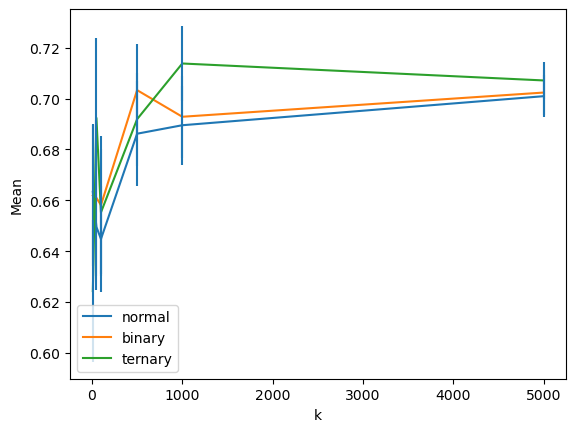

In [38]:
# Calculate means and confidence intervals
means = {}
conf_intervals = {}
for weight_type, parameters in results.items():
    means[weight_type] = {}
    conf_intervals[weight_type] = {}
    for k, values in parameters.items():
        means[weight_type][k] = np.mean(values)
        conf_intervals[weight_type][k] = stats.t.interval(
            0.95, len(values) - 1, loc=np.mean(values), scale=stats.sem(values)
        )


# Prepare x-axis values (parameter k)
x_values = list(results.values())[0].keys()

# Plot each weight type as a separate line
for weight_type in results.keys():
    y_values = [means[weight_type][k] for k in x_values]
    conf_intervals_lower = [conf_intervals[weight_type][k][0] for k in x_values]
    conf_intervals_upper = [conf_intervals[weight_type][k][1] for k in x_values]

    # Plot the line
    plt.plot(x_values, y_values, label=weight_type)

    # Plot the confidence intervals as error bars
    plt.errorbar(
        x_values,
        y_values,
        yerr=[
            np.array(y_values) - np.array(conf_intervals_lower),
            np.array(conf_intervals_upper) - np.array(y_values),
        ],
        fmt="none",
    )

# Add labels and legend
plt.xlabel("k")
plt.ylabel("Mean")
plt.legend()

# Show the plot
plt.show()